# STA314 Final Project Report - YouTube Spam Comments

### Problem Statement

**Relevance and importance**







### Statistical Analyses

#### Exploratory Data Analysis

First, we check the columns of the data loaded:


`Columns: [COMMENT_ID, AUTHOR, DATE, CONTENT, VIDEO_NAME, CLASS]`

where `COMMENT_ID` gives the `ID` from `1` to `1369`. The `AUTHOR` gives the name of the person making the comment. The `DATE` gives the date the comment is made. The `CONTENT` provides the string of the comment. The `VIDEO_NAME` is the video name in which the comment was made on. The `CLASS` is the labelling, where `0` is non-spam, `1` is spam. (I want to give some examples from the data if it's possible to print output)

We can print the first `5` entries from our dataset:

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import seaborn as sns
import nltk
df = pd.read_csv("../Dataset/train.csv")
df_test = pd.read_csv("../Dataset/test.csv")

In [33]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,1,Brandon Pryor,2014-01-19 00:36:25,I dont even watch it anymore i just come here ...,PSY - GANGNAM STYLE(?????) M/V,0
1,2,Chelsea Yun,2015-05-23 07:17:09.691,i hate rap﻿,Eminem - Love The Way You Lie ft. Rihanna,0
2,3,Sofia Aristizabal,2014-09-09 00:43:52,"I loved, she is amazing.. OMG your eyes*_*﻿",Katy Perry - Roar,0
3,4,said abdesalam,2015-05-24 07:35:13.754,song is bad﻿,Eminem - Love The Way You Lie ft. Rihanna,0
4,5,crazy girl,2015-05-23 23:26:05.305,tension⤴︎⤴︎﻿,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",0


Next, we can check out the distribution of the comment lengths:

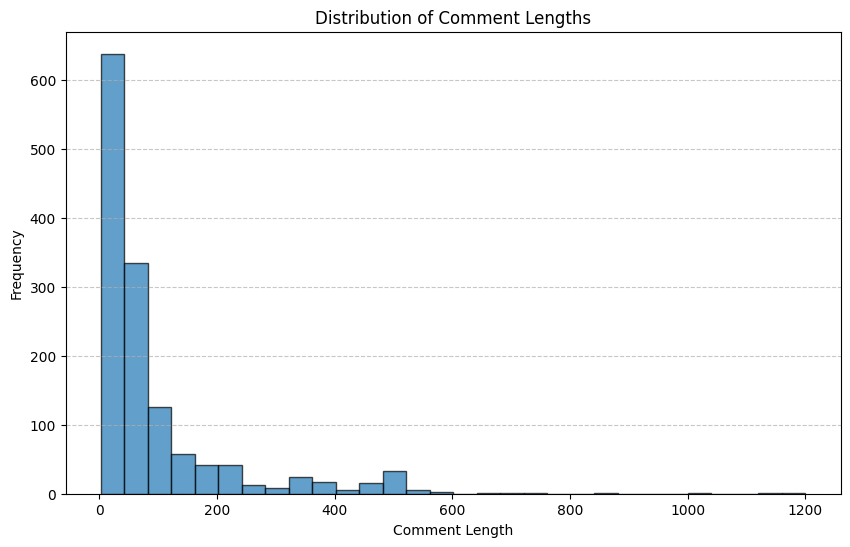

count    1369.000000
mean       95.598977
std       129.375097
min         3.000000
25%        28.000000
50%        48.000000
75%        99.000000
max      1200.000000
Name: Content_Length, dtype: float64


In [44]:
# Add a column for the lengths of the comments
df['Content_Length'] = df['CONTENT'].apply(len)

# Plot the distribution of the lengths
plt.figure(figsize=(10, 6))
plt.hist(df['Content_Length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print stats
print(df['Content_Length'].describe())

We see that the comments range from 3-1200 characters, with the mean around 96 characters. Notice that more than 50% of them are 48 characters or smaller, and 75% of them are under 99 characters.

We can also get the class proportions:

Class Proportions:
CLASS
1    0.518627
0    0.481373
Name: proportion, dtype: float64


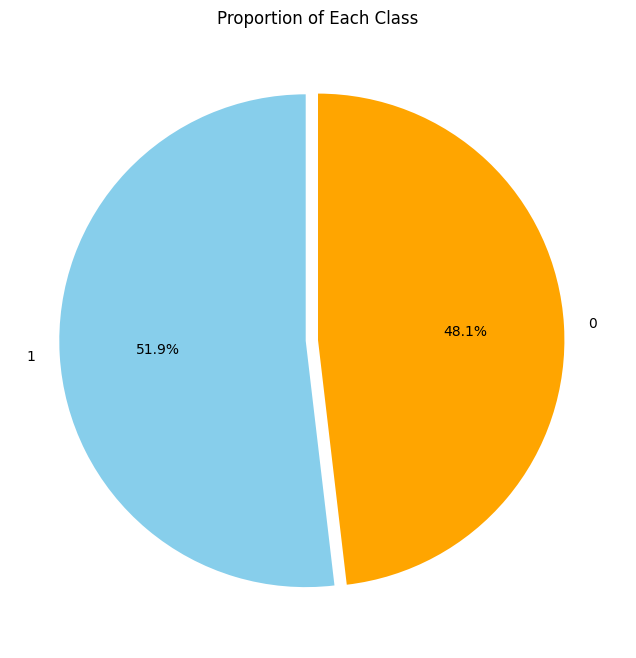

In [45]:
class_proportions = df['CLASS'].value_counts(normalize=True)

# Display the proportions
print("Class Proportions:")
print(class_proportions)

# Plot the proportions
plt.figure(figsize=(8, 8))
class_proportions.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'orange'],
    labels=class_proportions.index,
    explode=[0.05, 0]  # Slightly separate one slice for emphasis
)
plt.title('Proportion of Each Class')
plt.ylabel('')  # Remove the y-label for better appearance
plt.show()

We see that 51.86% fo the data are spam, and 48.14% of the data are not spam. There is no extreme class imbalance.

Next, we can get our most common non-stop words:

In [46]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Ensure you have the stopwords
nltk.download('stopwords')

# Define stop words for filtering
stop_words = set(stopwords.words('english'))

# Tokenize and filter non-stop words
def get_non_stop_words(content):
    # Tokenize the words
    words = content.split()
    # Filter out stop words and non-alphabetic words
    non_stop_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return non_stop_words

# Extract all non-stop words from the dataframe
all_words = []
df['CONTENT'].apply(lambda content: all_words.extend(get_non_stop_words(content)))

# Count the most common words
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Display the most common non-stop words
print("Most Common Non-Stop Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common Non-Stop Words:
check: 383
video: 192
like: 153
please: 137
song: 134
subscribe: 131
love: 130
music: 86
new: 84
channel: 81
guys: 71
get: 69
make: 65
money: 59
people: 59
hey: 54
katy: 52
comment: 49
best: 48
know: 48


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svishwa4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top Words for Class 0:
love: 98
song: 97
like: 48
video: 45
best: 35
katy: 35
billion: 32
views: 31
shakira: 22
people: 21
good: 21
get: 20
perry: 20
years: 19
still: 19
old: 17
party: 14
youtube: 13
music: 13
one: 12

Top Words for Class 1:
check: 377
video: 147
please: 137
subscribe: 131
like: 105
new: 83
channel: 81
music: 73
guys: 70
make: 60
money: 57
hey: 54
get: 49
comment: 44
called: 42
would: 42
thank: 41
people: 38
song: 37
know: 37


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svishwa4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


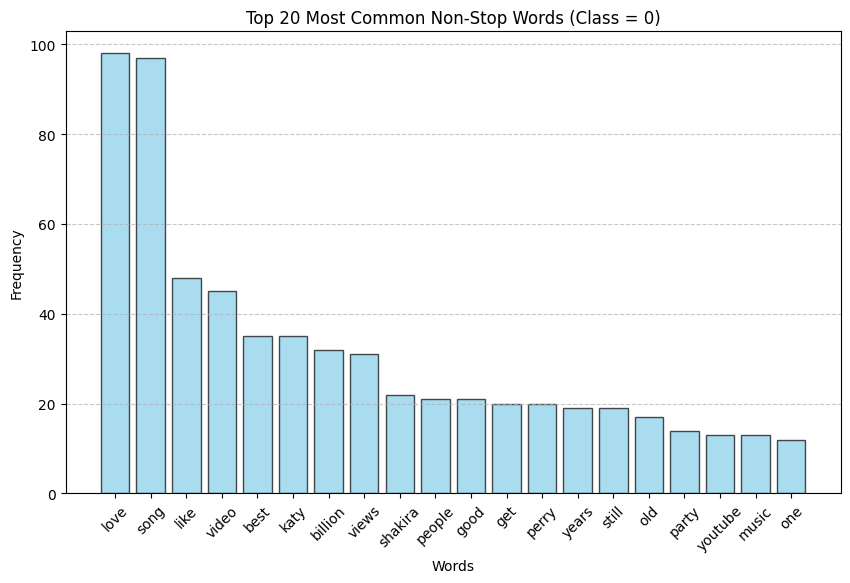

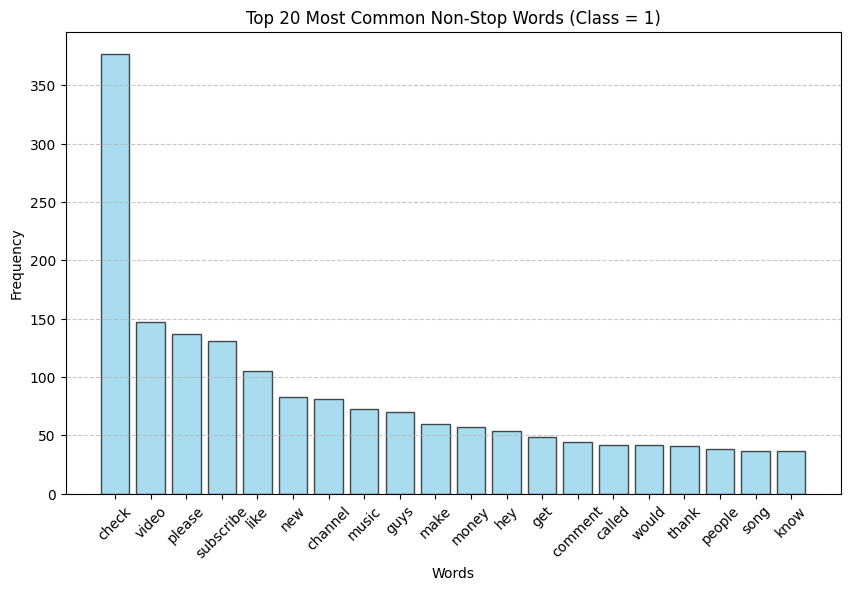

In [47]:


# Ensure you have the stopwords
nltk.download('stopwords')

# Define stop words for filtering
stop_words = set(stopwords.words('english'))

# Function to get non-stop words
def get_non_stop_words(content):
    words = content.split()
    non_stop_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return non_stop_words

# Function to get the most common words for a specific class
def get_most_common_words_by_class(df, class_label, n=20):
    class_df = df[df['CLASS'] == class_label]
    all_words = []
    class_df['CONTENT'].apply(lambda content: all_words.extend(get_non_stop_words(content)))
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get the top 20 words for CLASS = 0 and CLASS = 1
top_words_class_0 = get_most_common_words_by_class(df, class_label=0, n=20)
top_words_class_1 = get_most_common_words_by_class(df, class_label=1, n=20)

print("Top Words for Class 0:")
for word, count in top_words_class_0:
    print(f"{word}: {count}")

print("\nTop Words for Class 1:")
for word, count in top_words_class_1:
    print(f"{word}: {count}")

def plot_most_common_words(common_words, title):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue', edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_most_common_words(top_words_class_0, 'Top 20 Most Common Non-Stop Words (Class = 0)')
plot_most_common_words(top_words_class_1, 'Top 20 Most Common Non-Stop Words (Class = 1)')


We see that a lot of the non-spam comments have less frequent words for words like love, song, like, video, but the spam comments have really frequent words with check, video, please, subscribe.

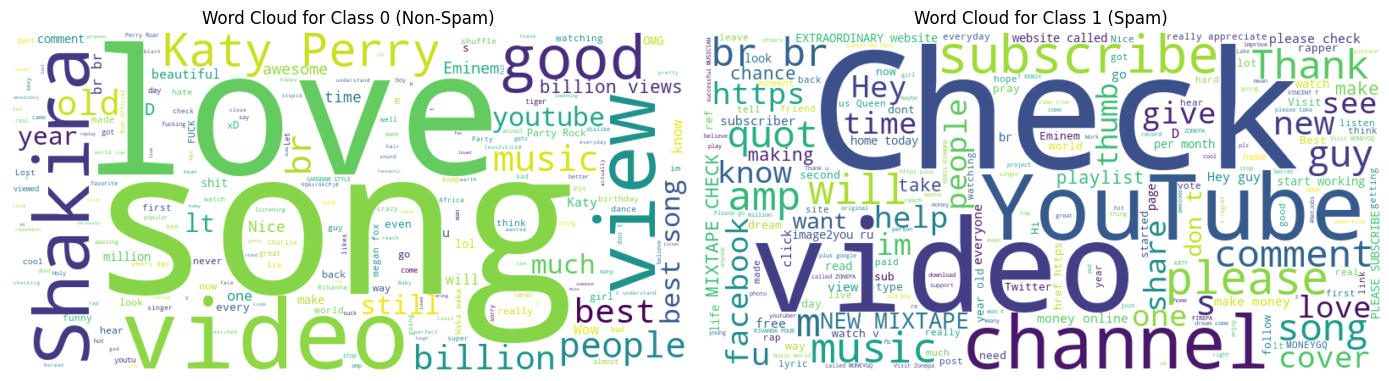

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# c0
class_0_text = " ".join(df[df['CLASS'] == 0]['CONTENT'].dropna())
wordcloud_class_0 = WordCloud(width=800, height=400, background_color="white").generate(class_0_text)

# Class 1
class_1_text = " ".join(df[df['CLASS'] == 1]['CONTENT'].dropna())
wordcloud_class_1 = WordCloud(width=800, height=400, background_color="white").generate(class_1_text)

# plot
plt.figure(figsize=(14, 7))

# Word Cloud for Class 0
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_class_0, interpolation='bilinear')
plt.title("Word Cloud for Class 0 (Non-Spam)")
plt.axis("off")

# Word Cloud for Class 1
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_class_1, interpolation='bilinear')
plt.title("Word Cloud for Class 1 (Spam)")
plt.axis("off")

plt.tight_layout()
plt.show()



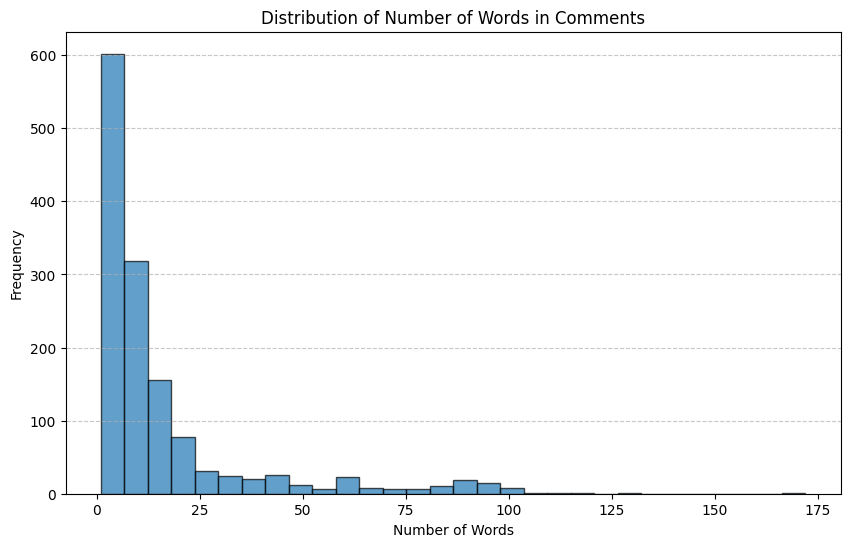

count    1369.000000
mean       15.829072
std        21.612720
min         1.000000
25%         4.000000
50%         7.000000
75%        16.000000
max       172.000000
Name: Word_Count, dtype: float64


In [49]:
df['Word_Count'] = df['CONTENT'].apply(lambda content: len(content.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['Word_Count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Number of Words in Comments')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(df['Word_Count'].describe())

The number of words per comment ranges from 1 to 172, with an average of approximately 16 words per comment. Half of the comments have 7 words or fewer, while the top 25% of comments contain 16 or more words. We have a skewed distribution here.

Let's also check out the most commented videos:

<Axes: title={'center': 'Top 10 Most Commented Videos'}, xlabel='VIDEO_NAME'>

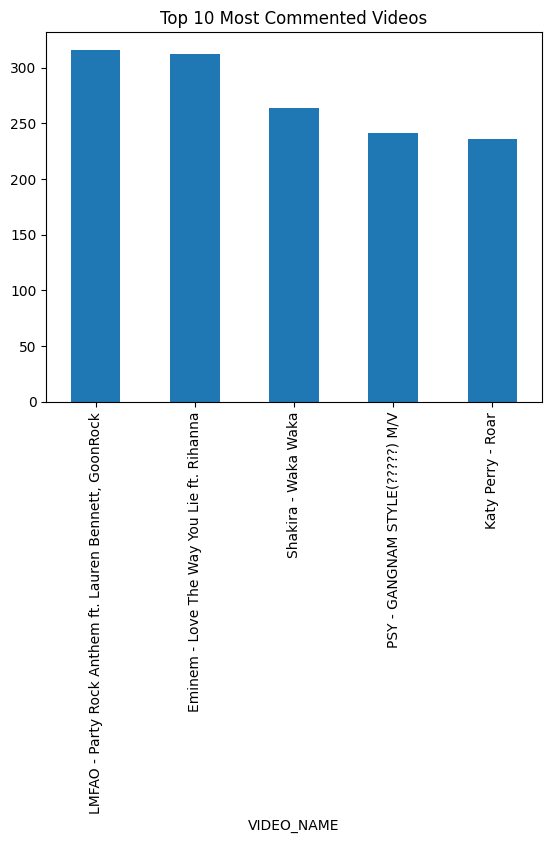

In [50]:
video_counts = df['VIDEO_NAME'].value_counts()
video_counts.head(10).plot(kind='bar', title='Top 10 Most Commented Videos')



We can also see the most common n-grams of comments:

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(df['CONTENT'])
ngram_counts = pd.DataFrame({'Ngram': vectorizer.get_feature_names_out(), 'Count': X.sum(axis=0).tolist()[0]})
ngram_counts = ngram_counts.sort_values(by='Count', ascending=False)
print(ngram_counts.head(10))


                     Ngram  Count
3112           check video     99
14238        video youtube     99
3118   check video youtube     89
2233                 br br     83
3025             check new     52
6783              http www     46
2238              br br br     44
8610             love song     37
6836             https www     35
9316           moneygq com     33


Lastly, we see that there is a lot of frequent n-grams such as video youtube and check video. Others such as http www and https www are most likely URLS, from spam.

Let's also see the average similarity of the words in non-spam, vs the average similarity of the words in the spam categories.

In [54]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

def train_word2vec(corpus):
    tokenized = [sentence.split() for sentence in corpus]
    model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4)
    return model

def calculate_average_similarity(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) < 2:
        return 0  # Not enough words for comparison
    similarities = cosine_similarity(word_vectors)
    upper_triangle = np.triu_indices(similarities.shape[0], k=1)
    avg_similarity = similarities[upper_triangle].mean()
    return avg_similarity

# Get class-specific texts and train Word2Vec
class_0_words = " ".join(df[df['CLASS'] == 0]['CONTENT']).split()
class_1_words = " ".join(df[df['CLASS'] == 1]['CONTENT']).split()

# Train Word2Vec models
class_0_model = train_word2vec(df[df['CLASS'] == 0]['CONTENT'])
class_1_model = train_word2vec(df[df['CLASS'] == 1]['CONTENT'])

# Calculate average similarities
class_0_similarity = calculate_average_similarity(class_0_words, class_0_model)
class_1_similarity = calculate_average_similarity(class_1_words, class_1_model)

print(f"Average Similarity (Class 0): {class_0_similarity:.4f}")
print(f"Average Similarity (Class 1): {class_1_similarity:.4f}")



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

After training a Word2Vec model, and adjusting for cosine similarity, we can see that a lot fo the spam comments are very similar to each other, with a 0.6453 average similarity, while the average similarity within non-spam words are very small: 0.0749

Finally, we fit a very simple benchmark model, where if the comment has the words `check`, `please`, `subscribe`, and `like`, then we classify it as spam

In [ ]:
target_words = ['check', 'please', 'subscribe', 'like']

for word in target_words:
    df[f'HAS_{word.upper()}'] = df['CONTENT'].dropna().apply(lambda x: 1 if word in x.lower() else 0)

word_class_relationship = df.groupby('CLASS')[[f'HAS_{word.upper()}' for word in target_words]].mean()

for word in target_words:
    correlation = df[f'HAS_{word.upper()}'].corr(df['CLASS'])
    print(f"Correlation between the presence of '{word}' and CLASS: {correlation:.4f}")


Correlation between the presence of 'check' and CLASS: 0.5322
Correlation between the presence of 'please' and CLASS: 0.3071
Correlation between the presence of 'subscribe' and CLASS: 0.3557
Correlation between the presence of 'like' and CLASS: 0.0569


We see that `check`, `subscribe` and `please` are highly correlated with spam words.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

target_words = ['check', 'please', 'subscribe', 'like']

df['HAS_TARGET_WORD'] = df['CONTENT'].dropna().apply(
    lambda x: 1 if any(word in x.lower() for word in target_words) else 0
)

X = df['HAS_TARGET_WORD'].values.reshape(-1, 1)
y = df['CLASS'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       145
           1       0.85      0.79      0.82       129

    accuracy                           0.84       274
   macro avg       0.84      0.83      0.83       274
weighted avg       0.84      0.84      0.84       274



We get a `0.84` accuracy by predicting if the class has those target words! (would this be bad statistical practice)



#### Data Cleaning

**Stop Words**

Stop words are typically the most frequently used words in a language and aare generally considered to have little semantic meaning in the conect of text analysic. These words rare often removed from text data during preprocessing because they can introduce noise without constributing significant information about the content or meaning of the text. Examples in English include "the", "is", "in", "at", "which", "and", etc. Many stop words are function words, which serve a grammatical purpose rather than conveying meaning. They help in structuring sentences but do not provide much insight into the topic or sentiment of the text.

By removing the stop words, the size of the vocabulary is reduced. We try to focus on words that carry important information, such as nouns, verbs, adjectives, and adverbs. By reducing the feature space of the model, we decrease the complexity and improve their performance. See below for a list of stop words.

In [ ]:
# Display the stop words used
# nltk.download('stopwords')
stop_words = stopwords.words('english')
print(f" Stop words used: \n", stop_words)


 Stop words used: 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sa


The process involved in data cleaning for our model:
1. First, we converted all the words into lower-case letters.
2. We experimented with removal of links, for example words starting with "http", "www", "https". We decided to keep these words as these features deemed to be signficant in model prediction.
3. We removed all non-ASCII characters.
4. We removed any characters that is not an alphabet, a digit, or a whitespace.
5. We removed whitespace characters such as spaces, tabs, and new lines.
6. We removed any digit, equivalent to `[0-9]`.
7. We removed any trailing whitespace characters from a string either at the beginning or at the end of the sentences.




#### Feature Selection

##### Vectorizing features
**TF-IDF vectorizer**
Put the math behind tf-idf vectorizer here..

**Bag of Words**
Explain BOW method..

**Word-to-vec vectorzer**
Explain word-to-vec model here..

**Features**

The process described above on data-cleaning, and then converting words into tokens can be performed with a library called `TfidfVectorizer`, with a single line: \
` feature_extraction = TfidfVectorizer(min_df = 2, stop_words = 'english', lowercase = True) `

Here, `min_df = 2` removes words that appear in less than 2 sentences. \
`stop_words = english` uses the same process for data cleaning as described in the data cleaning section above.\
This function returns a feature model that can then be used to get tokens from our traning dataset. This process results in a total of 884 features for our training dataset.

These parameters were chosen to give us the most simplistic model yet achieving highest performance.



### Result and Conclusion

For this classification problem, both Binary Logistic Regression and Support Vector Machine are valid models to train and predict the datasets on. Both models try to draw a hyperplane that separates the two classes, however Logistic Regression is a linear model, and SVM allows non-linear relationships between features and the binary outcome. 

In [63]:
# Load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer

# Read training dataset
df = pd.read_csv("../Dataset/train.csv")

# Remove irrelevant columns from the dataset
df = df.drop(["DATE", "VIDEO_NAME"], axis = 1)

# Load training features and responses
Xtrain = df["CONTENT"]
Ytrain = df["CLASS"]

# Split the training dataset with 80-20 split
Xtrain_train, Xtrain_test, Ytrain_train, Ytrain_test = \
train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 3)

# Change the min_df from 1 to 2, i.e, if a word appears in less than 2 sentences, drop it. 
feature_extraction = TfidfVectorizer(min_df = 2, stop_words = 'english', lowercase = True)
Xtrain_train_features = feature_extraction.fit_transform(Xtrain_train)
Xtrain_test_features = feature_extraction.transform(Xtrain_test)

#let's make sure the labels for Y are in int form e.g 0, 1 and not any other like "0", "1"
Ytrain_train = Ytrain_train.astype('int')
Ytrain_test = Ytrain_test.astype('int')

# Read the test data set and extract comments column
df_test = pd.read_csv("../Dataset/test.csv")
comments_test = df_test["CONTENT"]

# Use TF-IDF vectorizer to vectorize test data and extract features
Xtest_test_features = feature_extraction.transform(comments_test)

Assess the dataset for linearity, non-linearity, clusters, outliers, etc. 

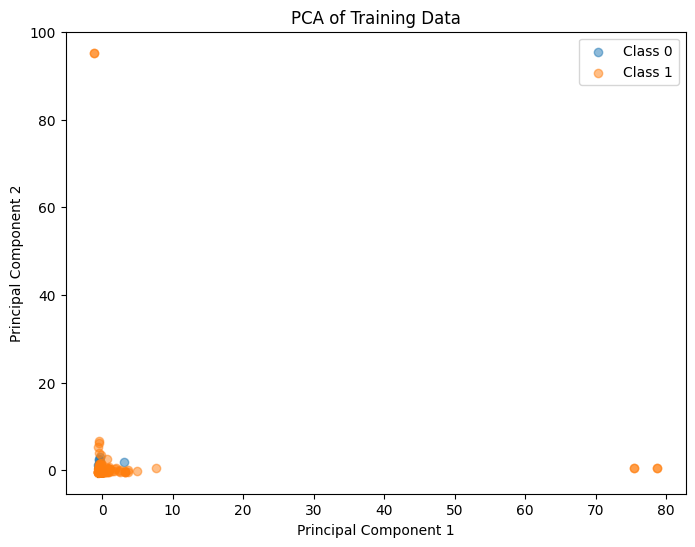

In [56]:

# Assess the dataset for linearity, non-linearity, clusters, outliers, etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features without centering
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(Xtrain_train_features)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.toarray())  # Convert to dense for PCA

# Since we have binary labels in Ytrain_train
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[Ytrain_train == 0, 0], X_pca[Ytrain_train == 0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_pca[Ytrain_train == 1, 0], X_pca[Ytrain_train == 1, 1], alpha=0.5, label='Class 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Training Data')
plt.legend()
plt.show()

PCA plot above shows how the data is generated along the first two principal components. These capture the direction of maximum variance in the data. Since we see one cluster near the origin we see a common pattern between spam and not  spam. But looking closely, there is a significant overlap between the two classes in that cluster. It can be very challenging for a linear model like Logistic Regression to classify these points in this scenario. 

There are also points further away from the cluster, these could be outliers or potentially unique samples. 

Since PCA performs is a linear transformation from high dimension to lower dimension, it may not capture complex, non-liinear relationships. Since we see data in the cluster being not well separated, we will consider t-SNE and UMAP for capturing the non-linear patterns.

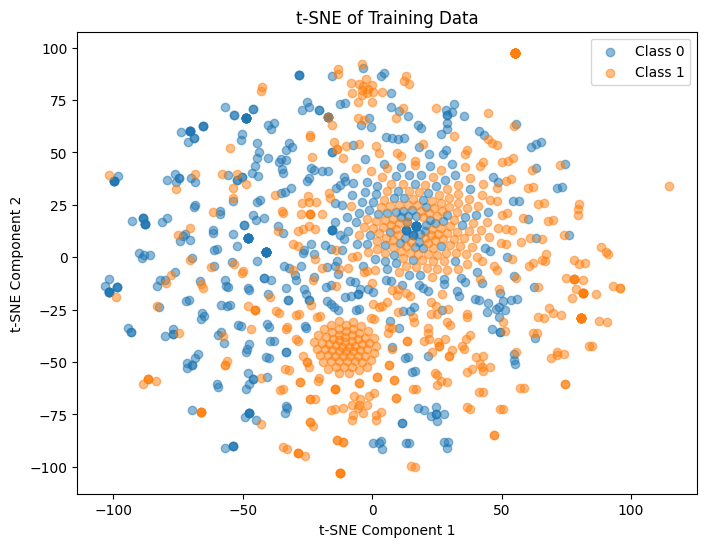

In [57]:
# t_SNE to plot features 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Standardize the features without centering
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(Xtrain_train_features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled.toarray())  # Convert to dense if necessary

# Plotting t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[Ytrain_train == 0, 0], X_tsne[Ytrain_train == 0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_tsne[Ytrain_train == 1, 0], X_tsne[Ytrain_train == 1, 1], alpha=0.5, label='Class 1')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Training Data')
plt.legend()
plt.show()


### t-distributed Stochastic Neighbour Embedding

The above plot shows how the data is distributed in the first two significant components of t-SNE. We see one cluster where the data is very well separated. This might indicate why we see a good prediction model from Logistic Regression model. However, if you look closely in the second cluster, you can see the data is between two classes are not very well separated. t-SNE is good at preserving local structures, so points that are close together in this plot are likely similar in the high-dimensional space. 

There are also many points that are scattered further away from these two main clusters. These could either be outliers or unique samples that must be treated with care. 



Next, we can also take a look UMAP, which preserves both local and global structures of the data better than t-SNE.

/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


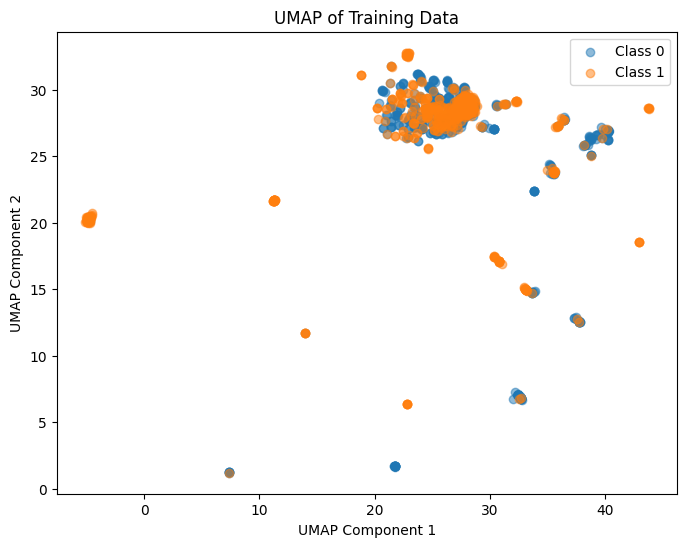

In [58]:
# UMAP for visualizing distribution of the data
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# Standardize the features without centering
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(Xtrain_train_features)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled.toarray())  # Convert to dense if necessary

# Plotting UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[Ytrain_train == 0, 0], X_umap[Ytrain_train == 0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_umap[Ytrain_train == 1, 0], X_umap[Ytrain_train == 1, 1], alpha=0.5, label='Class 1')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Training Data')
plt.legend()
plt.show()


There appears to be one large cluster and many tiny clusters distributed throughtout the plot. The large cluster also seems to have a lot of overlapping between two classes, which indicates difficulty in class separation. This is also something we saw in t-SNE plot. Once again, we see quite a few isolated points, which either suggests outliers, or unique samples that needs to be handled with care. 

One thing we can quickly notice are the clusters that form spam label. Notice one near the origin, and one around `(40,12)`. These might suggest stonger patterns in the data. As discussed in the Statistical Analyses section above, these might correspond to particular words such as "check" , "video", "please" and, "subscribe" as this indicates a strong pattern. 


Based one the above, we might as well consider looking at the outlier observatons. We will look at Distance-Based method called Z-Score. It calculates the Z-score for each feature and removes samples with scores above a certain threshold, for example, samples above 3 standard deviations. 

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Assume Xtrain_train_features is a dense matrix for simplicity
X_dense = Xtrain_train_features.toarray() if hasattr(Xtrain_train_features, "toarray") else Xtrain_train_features

# Calculate Z-scores
z_scores = np.abs(zscore(X_dense))

# Set a threshold for defining outliers
threshold = 3

# Identify outliers
outliers = np.where(z_scores > threshold)

# Remove outliers
X_cleaned = np.delete(X_dense, outliers[0], axis=0)
Y_cleaned = np.delete(Ytrain_train, outliers[0], axis=0)

print("Original data shape:", X_dense.shape)
print("Cleaned data shape:", X_cleaned.shape)


Original data shape: (1095, 884)
Cleaned data shape: (25, 884)


Removing all sample above 3 standard deviations took our sample space from 1095 to just 25 samples. This removes data points that are identified as outliers based on the threshold from the mean value. We need to understand those samples for their unique features before removing them completely. 

Below the SVM model performace from the Z-score based outlier removal 

In [ ]:
## Prediction on the cleaned dataset using SVM model
from sklearn import svm
from sklearn.metrics import accuracy_score

# Parameters chosen from cross-validation
svmModel = svm.SVC(C=8, degree=0, gamma=0.5)

# Fit the training features to the SVM model. Use the vectorized data
# from TF-IDF vectorizer
svmModel.fit(X_cleaned, Y_cleaned)

# Conver Xtrain_test_features to a dense matrix for simplicity
Xtest_dense = Xtrain_test_features.toarray() if hasattr(Xtrain_test_features, "toarray") else Xtrain_test_features

# Predict traning and test dataset. Use cleaned training data and original test data(uncleaned)
predictionTrain_train = svmModel.predict(X_cleaned)
predictionTrain_test = svmModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE 
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using SVM: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using SVM: {accuracyTrain_test}")

Accuracy of traning data using SVM: 0.96
Accuracy of test data using SVM: 0.5437956204379562


In [ ]:
## Prediction on the cleaned dataset using LR model
from sklearn.linear_model import LogisticRegression

# Create an instance of a logistic regression model
logisticRegModel = LogisticRegression(C=4.281332398719396, solver='saga')
logisticRegModel = logisticRegModel.fit(X_cleaned, Y_cleaned)

# Predict traning and test dataset
predictionTrain_train = logisticRegModel.predict(X_cleaned)
predictionTrain_test = logisticRegModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using Logistic Regression: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using Logistic Regression: {accuracyTrain_test}")


Accuracy of traning data using Logistic Regression: 0.96
Accuracy of test data using Logistic Regression: 0.5437956204379562


Looks like Z-Score removed some important observation that are used for classification. After all those sample above 3 std may not be outliers. 

We will also look at an alternative to Z-Score for outlier detection, alled Isolation Forest, which is a tree-based model that isolates outlier by randomly partitioning the data. 

In [65]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_dense)

# Remove outliers
X_cleaned = X_dense[outliers != -1]
Y_cleaned = Ytrain_train[outliers != -1]

print("Original data shape:", X_dense.shape)
print("Cleaned data shape:", X_cleaned.shape)

Original data shape: (1095, 884)
Cleaned data shape: (1040, 884)


Points isolated quickly are likely outliers. A `contamination` value of 0.25 specifies the proportion of the dataset that is expected to be outliers.  `random_state` is used like a seed value for reproducing the same result and a value of `42` is common in practice. This method reduces our sample space from 1095 to 821. In contradiction to Z-score, this says those cluster pockets we saw in the plots above, are not really outliers, but have some unique properties in them that are helpful for classfication. 

In [68]:
## Prediction on the cleaned dataset using SVM model
from sklearn import svm
from sklearn.metrics import accuracy_score

# Parameters chosen from cross-validation
svmModel = svm.SVC(C=8, degree=0, gamma=0.5)

# Fit the training features to the SVM model. Use the vectorized data
# from TF-IDF vectorizer
svmModel.fit(X_cleaned, Y_cleaned)

# Conver Xtrain_test_features to a dense matrix for simplicity
Xtest_dense = Xtrain_test_features.toarray() if hasattr(Xtrain_test_features, "toarray") else Xtrain_test_features

# Predict traning and test dataset. Use cleaned training data and original test data(uncleaned)
predictionTrain_train = svmModel.predict(X_cleaned)
predictionTrain_test = svmModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE 
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using SVM: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using SVM: {accuracyTrain_test}")

Accuracy of traning data using SVM: 0.9971153846153846
Accuracy of test data using SVM: 0.9416058394160584


Let's use gridsearch cross-validation method to find the best parameters for SVM model

In [ ]:
# Use gridsearch CV to find the best model prameters for SVM.
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# Create an SVM model
svmModel = svm.SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svmModel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_cleaned, Y_cleaned)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Predict training and test datasets with the best model
best_svm_model = grid_search.best_estimator_
predictionTrain_train = best_svm_model.predict(X_cleaned)
predictionTrain_test = best_svm_model.predict(Xtest_dense)

# Calculate accuracy
accuracyTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy on training data: {accuracyTrain_train}")

accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy on test data: {accuracyTrain_test}")


Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy on training data: 0.9807692307692307
Accuracy on test data: 0.9562043795620438


Compare it to the previous run of gridsearch CV that overfitted the traning samples: \
Best parameters: {'C': 8, 'degree': 0, 'gamma': 0.5, 'kernel': 'rbf'}\
Accuracy on training data: 0.9971153846153846\
Accuracy on test data: 0.9416058394160584

We purposely chose some parameters that wasn't overfitting the model. Moreover, from our discussion above, we want to look for a model that can fit a polynomial of degree > 1 since we see non-linearity in the data.

In [ ]:
## Prediction on the cleaned dataset using LR model
from sklearn.linear_model import LogisticRegression

# Create an instance of a logistic regression model
logisticRegModel = LogisticRegression(C=4.281332398719396, solver='saga')
logisticRegModel = logisticRegModel.fit(X_cleaned, Y_cleaned)

# Predict traning and test dataset
predictionTrain_train = logisticRegModel.predict(X_cleaned)
predictionTrain_test = logisticRegModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using Logistic Regression: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using Logistic Regression: {accuracyTrain_test}")

Accuracy of traning data using Logistic Regression: 0.9817307692307692
Accuracy of test data using Logistic Regression: 0.9598540145985401


Let's use gridsearch cross-validation method to find the best parameters for Logistic Regression model.

In [70]:
# Use gridsearch CV to find the best model prameters for LR. 
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': np.logspace(-3, 3, 5),
    'solver': ['liblinear', 'saga', 'lbfgs', 'sag'],
    'max_iter': [75, 100, 200]
}

# Create a logistic regression model
logisticRegModel = LogisticRegression()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logisticRegModel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_cleaned, Y_cleaned)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Predict training and test datasets with the best model
best_logistic_model = grid_search.best_estimator_
predictionTrain_train = best_logistic_model.predict(X_cleaned)
predictionTrain_test = best_logistic_model.predict(Xtest_dense)

# Calculate accuracy
accuracyTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy on training data: {accuracyTrain_train}")

accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy on test data: {accuracyTrain_test}")


/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/P

Best parameters: {'C': np.float64(10.0), 'max_iter': 200, 'solver': 'saga'}
Accuracy on training data: 0.9923076923076923
Accuracy on test data: 0.9562043795620438


### Discussion

### References

### Code

#### Data Cleaning
**Stop Words**


In [ ]:
# Import libraries

import nltk
from nltk.corpus import stopwords